In [104]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.utils import get_data_and_feed
from src.induction_pinn import PINN, numpy_to_tensor, train
from typing import Optional, Union
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
def plot_simulation(t=None, y=None, full_df: Optional[pd.DataFrame] = None, train_df: Optional[pd.DataFrame] = None, net_df: Optional[pd.DataFrame] = None, title: Optional[str] = None):
    fig, axs = plt.subplots(2, 1, figsize=(12, 6))
    
    axs[0].scatter(full_df['RTime'].values, full_df['Biomass'].values, label='Biomass')
    if y is not None:
        axs[0].plot(t, y[0], label='Simulated Biomass')
    if net_df is not None:
        axs[0].scatter(net_df['RTime'].values, net_df['Biomass'].values, marker='x', label='Predicted Biomass', color='green')
    
    axs[0].scatter(full_df['RTime'].values, full_df['Glucose'].values, label='Glucose')
    if y is not None:
        axs[0].plot(t, y[1], label='Simulated Glucose')
    if net_df is not None:
        axs[0].scatter(net_df['RTime'].values, net_df['Glucose'].values, marker='x', label='Predicted Glucose', color='orange')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Concentration')
    axs[0].legend()
    
    axs[1].scatter(full_df['RTime'].values, full_df['Protein'].values, label='Protein')
    if y is not None:
        axs[1].plot(t, y[2], label='Simulated Protein', color='red')
    if net_df is not None:
        axs[1].scatter(net_df['RTime'].values, net_df['Protein'].values, marker='x', label='Predicted Protein', color='purple')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Protein')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()
    
def simulate(df: pd.DataFrame, F: np.float32, mu_max, Ks, Yxs):
    mu_max = mu_max
    Ks = Ks
    Yxs = Yxs
    F = F
    Sin = 1.43 * 200
    
    def alpha(t):
        c1 = 0.029859
        c2 = 0.140495
        return c1 * (1 - np.exp(-c2 * t))

    def system_ode(t, y):
        X, S, P, V = y
        mu = mu_max * S / (Ks + S)
        dXdt = mu * X + F * X / V
        dSdt = - mu * X / Yxs + F * (Sin - S) / V
        dPdt = alpha(t) * X - P * F / V
        dVdt = F
        return [dXdt, dSdt, dPdt, dVdt]
    
    t_start, t_end = df['RTime'].min(), df['RTime'].max()
    t_span = (t_start, t_end)
    y0 = [df['Biomass'].iloc[0], df['Glucose'].iloc[0], df['Protein'].iloc[0], df['V'].iloc[0]]

    t_eval = np.linspace(t_start, t_end, 10000)
    sol = solve_ivp(system_ode, t_span=t_span, \
        y0=y0, t_eval=t_eval)
    
    for i in range(sol.y.shape[0]):
        sol.y[i][sol.y[i] < 0] = 0

    return sol

def get_predictions_df(net: nn.Module, df: pd.DataFrame):
    net_df = pd.DataFrame()
    t_test = df['RTime'].values
    t_test = numpy_to_tensor(t_test)
    net_df["RTime"] = df["RTime"].values
    net_df["Biomass"] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df["Glucose"] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    net_df["Protein"] = net.forward(t_test).detach().cpu().numpy()[:, 2]
    net_df["V"] = net.forward(t_test).detach().cpu().numpy()[:, 3]
    net_df.loc[net_df['Glucose'] < 0, 'Glucose'] = 0
    return net_df


In [106]:
FILENAME = '../data/data_processed.xlsx'
EXPERIMENT = 'BR02'

_df, feeds = get_data_and_feed(FILENAME, EXPERIMENT)

# Only Induction data
_df = _df[_df['Process'] == 'FBI']
feeds = feeds[feeds['Induction'] == 1]

F = feeds['F'].values[0] / 1000 # Transform to mL/H

print(f'Dataset shape: {_df.shape}')

Dataset shape: (8, 8)


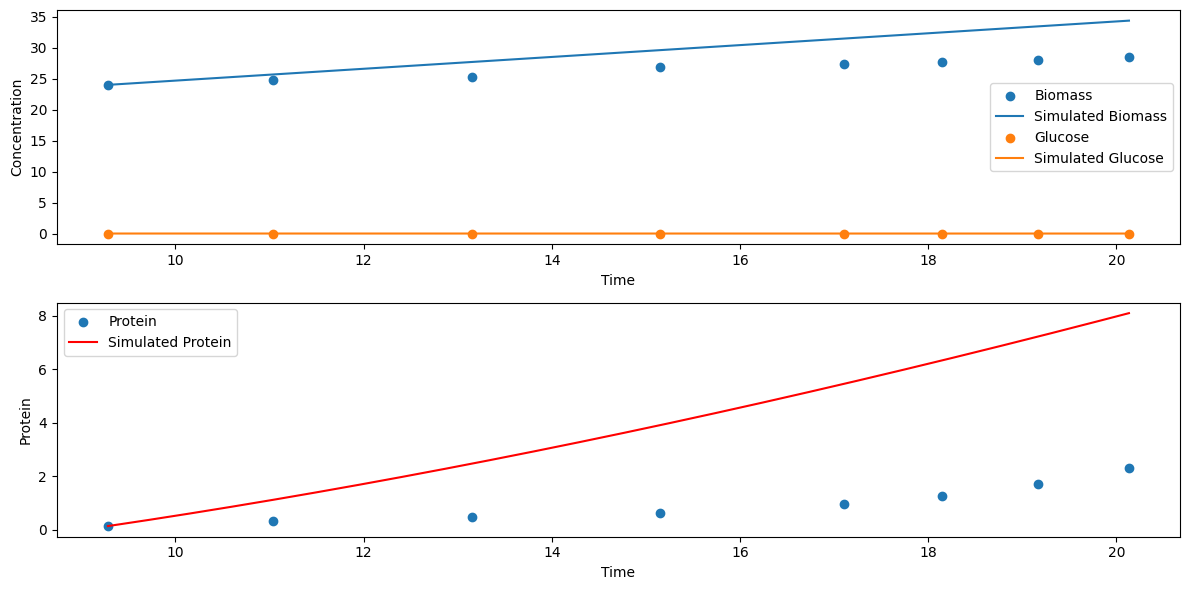

In [107]:
solution = simulate(_df, F, 0.870, 0.214, 0.496)
plot_simulation(solution.t, solution.y, _df)

In [108]:
t_start, t_end = _df['RTime'].min(), _df['RTime'].max()

net = PINN(1, 4, t_start, t_end)

t_train = numpy_to_tensor(_df['RTime'].values)
Biomass_train = numpy_to_tensor(_df['Biomass'].values)
Glucose_train = numpy_to_tensor(_df['Glucose'].values)
Protein_train = numpy_to_tensor(_df['Protein'].values)
V_train = numpy_to_tensor(_df['V'].values)
u_train = torch.cat([Biomass_train, Glucose_train, Protein_train, V_train], 1)

net = train(net, t_train, u_train, _df, F, num_epochs=10000, verbose=True)

  0%|          | 20/10000 [00:00<01:53, 88.31it/s]

 12%|█▏        | 1212/10000 [00:10<01:12, 121.45it/s]

In [ ]:
print(f'c1 = {net.c1.item():.6f}')
print(f'c2 = {net.c2.item():.6f}')

c1 = 0.232774
c2 = 0.007877


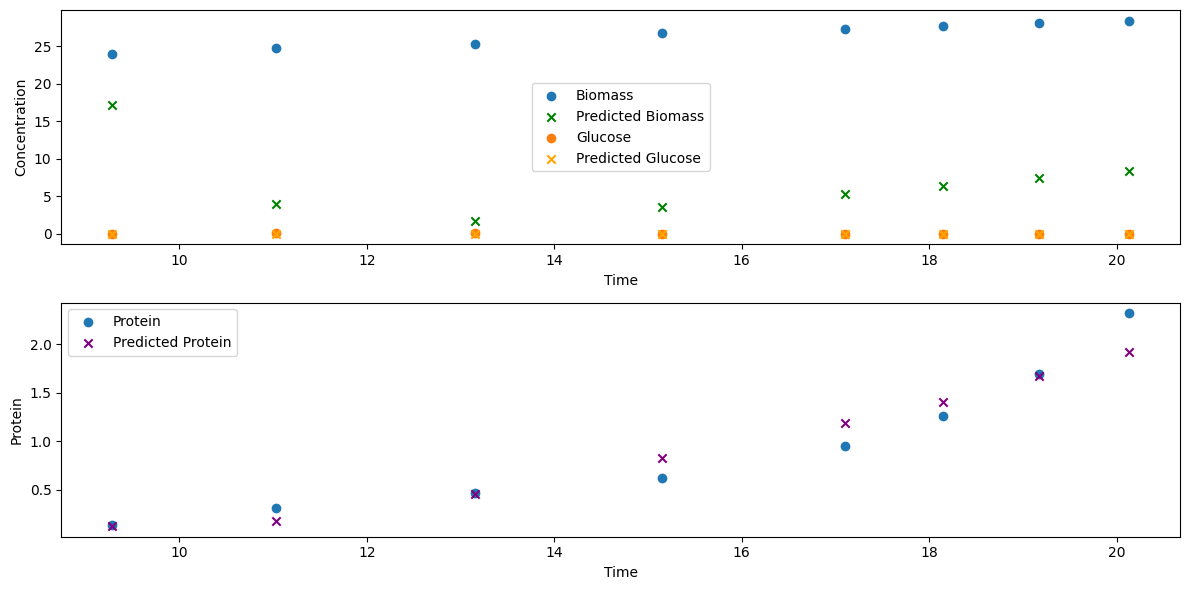

In [ ]:
net_df = get_predictions_df(net, _df)

plot_simulation(full_df=_df, net_df=net_df)